In [1]:
import os
import random

from PIL import Image

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import transforms

import numpy as np

import pandas as pd

In [2]:
TRAIN_IMAGES_PATH = os.sep.join(["..", "resized_images_augmentated"]) # относительный путь к папке с картинками

CSV_PATH = "sample_full_augm.csv"

IMAGE_NORMAL_SIZE = (224, 224)
GRAM_SIZE = 512

RANDOM_SEED = 4545435
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CPU = torch.device("cpu")

In [3]:
class MyCustomDataset(Dataset):
    def __init__(self, dict_path):
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.class_dict = pd.read_csv(dict_path)
        
    def __getitem__(self, index):
        row = self.class_dict.iloc[index]
        file_path = row[1]
        
        data = Image.open(file_path).convert("RGB").resize(IMAGE_NORMAL_SIZE)
        data = self.transformations(data)  # (3)
        
        label = row[2]
        
        return data, label

    def __len__(self):
        return self.class_dict.index.shape[0]
    

class StyleMatrix(nn.Module):
    def __init__(self):
        super(StyleMatrix, self).__init__()

    def forward(self, input_):
         return __class__.gram_matrix(input_)
    
    @staticmethod
    def gram_matrix(inp): # исправленная версия
        a, b, c, d = inp.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c, d)=dimensions of a f. map (N=c*d)

        features = inp.view(a, b, c * d)  # resise F_XL into \hat F_XL
        G = torch.empty((a, b, b))
        for i in range(a):
            G[i] = torch.mm(features[i], features[i].t())

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

## Урезанная сеть ResNet18

In [4]:
resnet_18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True).to(DEVICE)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
our_resnet_18 = torch.nn.Sequential(*list(resnet_18.children())[:-1]+[StyleMatrix()])
torch.save(our_resnet_18.state_dict(), "our_resnet_18.pth") # на случай, если придется пересохранять сетку
our_resnet_18.load_state_dict(torch.load("our_resnet_18.pth"))
our_resnet_18.eval()

Using cache found in C:\Users\Valery/.cache\torch\hub\pytorch_vision_v0.6.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## Создание списка всех изображений (номер - путь к файлу - класс) 
### Аргументы:  
**file_path**-название результирующего файла,  
**cut_factor**-как "порезать" датасет (cut_factor=2 будет выбирать только каждую 2 картинку.  
Чем больше cut_factor-тем меньше датасет, выбрать полный датасет-cut_factor=1)

In [17]:
def generate_csv_classes(file_path, cut_factor=1):
    header = "filename,full_filename,num_class"
    data = header + "\n"
    
    timeframes = os.listdir(TRAIN_IMAGES_PATH)
    
    with open(file_path, "w+") as file_csv:
        for count_class, timeframe in enumerate(timeframes):
            timeframe_images_path = TRAIN_IMAGES_PATH+ os.sep + timeframe
            images = os.listdir(timeframe_images_path)
            img_count = 0
            for image_name in images:
                img_count+=1
                if img_count % cut_factor == 0: 
                    image_index = image_name.split(".")[0]
                    image_path = timeframe_images_path + os.sep + image_name
                    count_class_this = "0" if count_class <= 16 else str(count_class-16)
                    data += "{},{},{}\n".format(image_index, image_path, count_class_this)
                
        file_csv.write(data)
CUT_FACTOR = 6
generate_csv_classes(CSV_PATH, cut_factor=CUT_FACTOR)

## Загрузчики данных

In [5]:
VALIDATION_SPLIT = 0.4
TEST_SPLIT = 0.5
BATCH_SIZE = 5

In [6]:
data = MyCustomDataset(CSV_PATH)

dataset_size = len(data) 
indices = list(range(dataset_size)) 

split = int(VALIDATION_SPLIT * dataset_size)

np.random.seed(RANDOM_SEED) 
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices) 
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=0, sampler=train_sampler)

val_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=0, sampler=valid_sampler)

print("Number of batches in train loader: {} ({} images)".format(len(train_loader), len(train_loader) * BATCH_SIZE))
print("Number of batches in validation loader: {} ({} images)".format(len(val_loader), len(val_loader) * BATCH_SIZE))

Number of batches in train loader: 1984 (9920 images)
Number of batches in validation loader: 1322 (6610 images)


## Отбор признаков (можно пропустить)
Каждую итерацию исключается ровно половина признаков, выявление наиболее важных происходит на 500, 1000, ... объектах в зависимости от текущего количества неисключенных признаков. В конце остаётся ~4000, которые можно сохранить в csv или продолжить работу.


In [20]:
N_BATCHES = len(train_loader)
MAX_FEATURES = 10000

In [21]:
from sklearn.feature_selection import SelectKBest, chi2

def select_features(loader, model, mask, n_batches, k):
    X = []
    y = []
    for i, (images, labels) in enumerate(loader):
        if i > n_batches:
            break
        actual_batch_size = min(images.shape[0], BATCH_SIZE)
        G_matrices = model(torch.reshape(images, (actual_batch_size, 3, *IMAGE_NORMAL_SIZE)).to(DEVICE))
        for j in range(actual_batch_size):
            X.append(G_matrices[j].cpu().detach().numpy().reshape((1, GRAM_SIZE*GRAM_SIZE))[0][mask])
        y += labels.tolist()
        if (i % 500) == 0:
            print(i, "batches out of", n_batches, "completed")
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y)
    print("Selected", k, "features from", len(mask), "with", n_batches*BATCH_SIZE, "objects")
    return mask[list(selector.get_support(indices=True))]

In [ ]:
# mask_history = []
mask = np.array([i for i in range(GRAM_SIZE*GRAM_SIZE)])

start_time = time.time()
mask = select_features(train_loader, our_resnet_18, mask, N_BATCHES // 2, MAX_FEATURES * 4)
print((time.time() - start_time), 'seconds spent\n')
mask = select_features(train_loader, our_resnet_18, mask, N_BATCHES, MAX_FEATURES)
print((time.time() - start_time), 'seconds spent\n')

# while len(mask) > MAX_FEATURES:
#     start_time = time.time()
#     actual_n_batches = N_BATCHES
#     mask = select_features(train_loader, our_resnet_18, mask, actual_n_batches, len(mask) // 2)
#     mask_history.append(mask)
#     print((time.time() - start_time), 'seconds spent\n')

0 batches out of 992 completed
500 batches out of 992 completed


Сохраним номера признаков на разных шагах в файл на случай их утери.

In [12]:
from numpy import asarray, save

save('features_resnet_kbest.npy', asarray(mask))

In [85]:
# from numpy import asarray, save

# save('features_resnet_65000.npy', asarray(mask_history[-4]))
# save('features_resnet_32000.npy', asarray(mask_history[-3]))
# save('features_resnet_16000.npy', asarray(mask_history[-2]))
# save('features_resnet_8000.npy', asarray(mask_history[-1]))

## Пути к файлам

In [30]:
FEATURES_MASK_PATH = "features_resnet_kbest.npy" # путь к файлу с маской признаков (в данном случае на 8192 штуки)
TRAIN_CSV_PATH = "train.csv"
VALIDATION_CSV_PATH = "val.csv"
TEST_CSV_PATH = "test.csv"

## Перегонка картинок в их признаковое описание
Выполнение этого блока необходимо, если у вас нет сконвертированных данных в .csv

Если таковые есть, то этот блок стоит пропустить

In [31]:
mask = np.load(FEATURES_MASK_PATH)
print("Number of selected features:", len(mask))

FileNotFoundError: [Errno 2] No such file or directory: 'features_resnet_8000'

In [9]:
def get_features_dataset(loader, features, model):
    X = []
    y = []
    size = len(loader)
    for i, (images, labels) in enumerate(loader):
        actual_batch_size = min(images.shape[0], BATCH_SIZE)
        G_matrices = model(torch.reshape(images, (actual_batch_size, 3, *IMAGE_NORMAL_SIZE)).to(DEVICE))

        for j in range(actual_batch_size):
            X.append(G_matrices[j].cpu().detach().numpy().reshape((1, GRAM_SIZE*GRAM_SIZE))[0][features])
        y += labels.tolist()
        if (i % 1000) == 0:
            print(i, "batches out of", size, "completed")
    print("Converting results to Pandas DataFrame...")
    df = pd.DataFrame(data=X)
    df["label"] = y
    print("Done.")
    return df

df_train = get_features_dataset(train_loader, mask, our_resnet_18)

0 batches out of 1984 completed
1000 batches out of 1984 completed
Converting results to Pandas DataFrame...
Done.


In [10]:
df_val = get_features_dataset(val_loader, mask, our_resnet_18)

0 batches out of 1322 completed
1000 batches out of 1322 completed
Converting results to Pandas DataFrame...
Done.


In [11]:
test_size = int(df_val.shape[0] * TEST_SPLIT)
df_test, df_val = df_val.iloc[:test_size, :], df_val.iloc[test_size:, :]

In [12]:
df_train.shape, df_val.shape, df_test.shape

((9917, 10001), (3305, 10001), (3305, 10001))

In [13]:
# можно пропустить, если сохранение не требуется
df_train.to_csv(TRAIN_CSV_PATH)
print("Saved train data")

df_val.to_csv(VALIDATION_CSV_PATH)
print("Saved validation data")

df_test.to_csv(TEST_CSV_PATH)
print("Saved test data")

Saved train data
Saved validation data
Saved test data


## Загрузка данных из CSV файлов
Этот блок необходимо выполнить, если был пропущен предыдущий

In [ ]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
print("Loaded train data")

df_val = pd.read_csv(VALIDATION_CSV_PATH)
print("Loaded validation data")

df_test = pd.read_csv(TEST_CSV_PATH)
print("Loaded test data")

## Обучение и тестирование моделей

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix
import joblib

In [18]:
X_train = df_train.loc[:, df_train.columns != "label"]
X_test = df_test.loc[:, df_test.columns != "label"]
X_val = df_val.loc[:, df_val.columns != "label"]

y_train = df_train["label"]
y_test = df_test["label"]
y_val = df_val["label"]

In [29]:
def replace_1300(y): # объединение малочисленных классов (теперь не обязателно (можно будет удалить))
    for i in y.index:
        y[i] = max(y[i], 16)
        
replace_1300(y_train)
replace_1300(y_test)
replace_1300(y_val)

<ipython-input-29-a8381ee3d08c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = max(y[i], 16)


## PCA (не тестировалось, может долго работать)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6000, svd_solver='randomized')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

KeyboardInterrupt: 

## Используем SGD

In [19]:
sgd = SGDClassifier(n_jobs=-1, verbose=0)
sgd.fit(X_train, y_train)

SGDClassifier(n_jobs=-1)

Number of train examples: 9920
0.22783661119515886
16.238124054462936


c:\users\valery\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


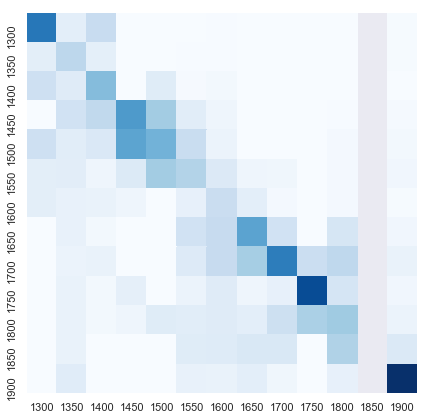

In [20]:
sgd_predict = sgd.predict(X_val)
print("Number of train examples:", len(train_loader) * BATCH_SIZE )
print(f1_score(y_val, sgd_predict, average="micro"), mean_squared_error(y_val, sgd_predict), sep="\n")

cmat = confusion_matrix(y_val, sgd_predict)
plt.figure(figsize=(7, 7))
sns.heatmap(
    cmat / np.sum(cmat, axis=0),
    annot=False, cbar=False,
    xticklabels=[1300 + i*50 for i in range(13)],
    yticklabels=[1300 + i*50 for i in range(13)],
    cmap="Blues") 
plt.show()

## Используем SVM

In [21]:
linear_svc = LinearSVC(verbose=2, max_iter=1000)
linear_svc.fit(X_train, y_train)

[LibLinear]

LinearSVC(verbose=2)

Number of train examples: 9920
0.3388804841149773
9.302269288956127


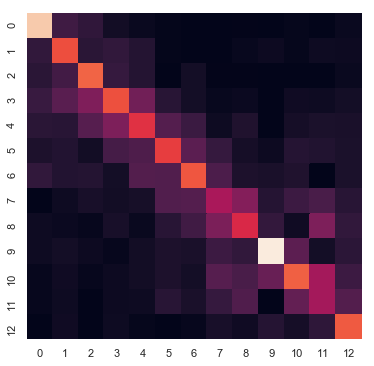

In [22]:
svc_predict = linear_svc.predict(X_test)
print("Number of train examples:", len(train_loader) * BATCH_SIZE )
print(f1_score(y_test, svc_predict, average="micro"), mean_squared_error(y_test, svc_predict), sep="\n")

cmat = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(6,6))
sns.heatmap(
    cmat / np.sum(cmat, axis=0),
    annot=False, cbar=False)
plt.show()

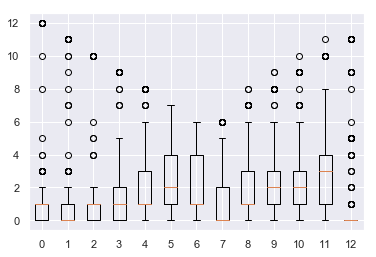

{'whiskers': [<matplotlib.lines.Line2D at 0x2d91b9e15c0>,
 'caps': [<matplotlib.lines.Line2D at 0x2d91b9e1cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d91b9e1198>],
 'medians': [<matplotlib.lines.Line2D at 0x2d91b9c4400>],
 'fliers': [<matplotlib.lines.Line2D at 0x2d91b9c4780>],
 'means': []}

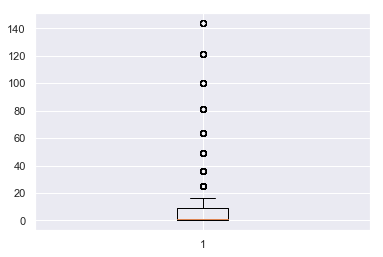

In [29]:
from sklearn.metrics import f1_score, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
NUM_OF_CLASSES = 13
print()
#[np.where(y_test==16)])
squared_error = np.power(y_test-svc_predict, 2)
squared_errors_by_classes = []
classes = list(range(NUM_OF_CLASSES))
for i in range(NUM_OF_CLASSES):
    index_mask = np.where(y_test==i)
    squared_errors_by_classes.append(
        np.power(
            np.power(y_test.values[index_mask]-svc_predict[index_mask], 2),
            1/2
        )
    )
plt.boxplot(squared_errors_by_classes, labels=classes)
plt.show()
plt.boxplot(squared_error)
